In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

%matplotlib inline

In [2]:
def show(data):
    data.plot(figsize=(16,9))

def cumret(ret):
    return (1 + ret).cumprod() - 1

In [17]:
# Earliest available date for VEU
# TODO: Do this study with analog indexes that go further back
start_dt = datetime.datetime(2007, 3, 8) 
end_dt = datetime.datetime(2015, 11, 28)

In [18]:
import pandas.io.data as web

SPY = web.DataReader("SPY", 'yahoo', start_dt, end_dt)['Adj Close']
VNQ = web.DataReader("VNQ", 'yahoo', start_dt, end_dt)['Adj Close']
VEU = web.DataReader("VEU", 'yahoo', start_dt, end_dt)['Adj Close']
TIP = web.DataReader("TIP", 'yahoo', start_dt, end_dt)['Adj Close']
TLT = web.DataReader("TLT", 'yahoo', start_dt, end_dt)['Adj Close']

In [19]:
universe = pd.concat([SPY, VNQ, VEU, TIP, TLT], axis=1, keys=['SPY', 'VNQ', 'VEU', 'TIP', 'TLT'])

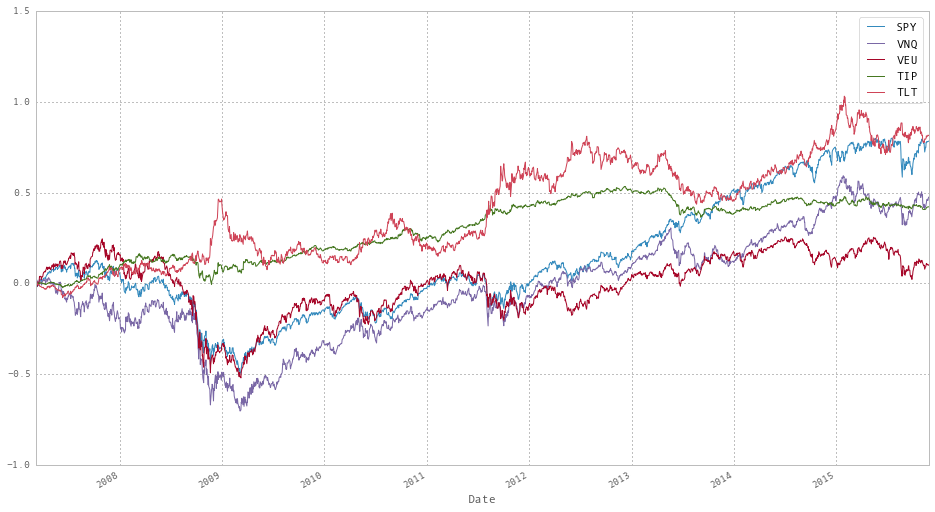

In [20]:
show(cumret(universe.pct_change().fillna(0)))

In [21]:
import portfolio
weights = [0.3, 0.2, 0.2, 0.15, 0.15]

# We have to convert the target market value weights above into
# per-share weighting (according to share prices)
price_weights = universe / universe.sum(axis=1)
target_price_weights = weights / price_weights

portfolio_prices = portfolio.portfolio_prices(universe, target_price_weights)
portfolio_returns = portfolio.portfolio_returns(universe, target_price_weights, 1)

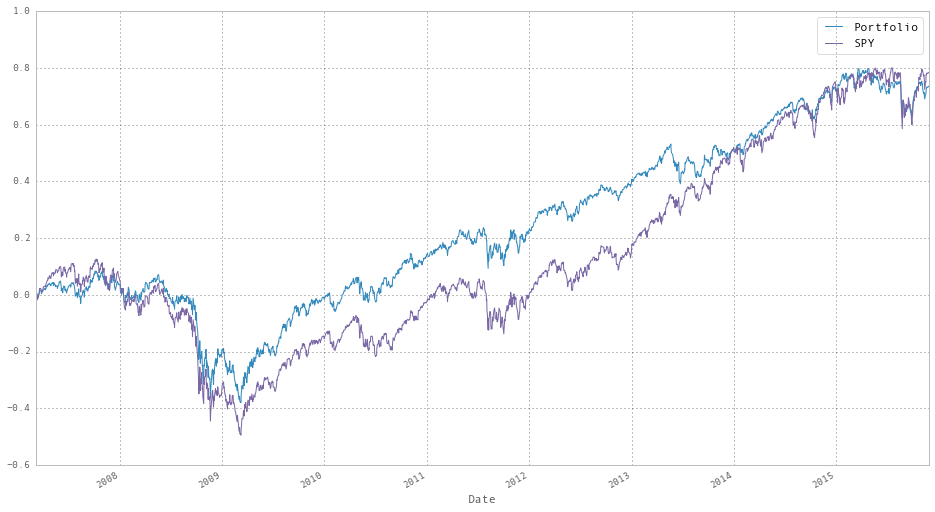

In [22]:
show(pd.concat([
            cumret(portfolio_returns[0]),
            cumret(SPY.pct_change())],
        axis=1,
        keys=['Portfolio', 'SPY']))

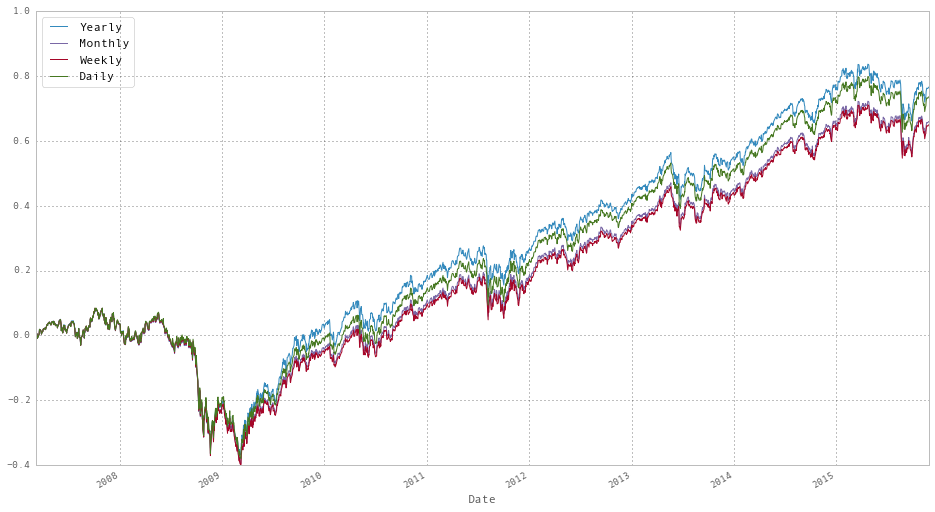

In [23]:
# Yearly rebalancing (preferred due to long term capital gains rules)
yearly_targets = target_price_weights.index[0::252]
yearly_weights = pd.DataFrame(index=universe.index, columns=universe.columns)
yearly_weights.loc[yearly_targets] = target_price_weights.loc[yearly_targets]
yearly_weights = yearly_weights.fillna(method='ffill')

# Monthly rebalancing (for comparative purposes)
monthly_rebalances = target_price_weights.index[0::21]
monthly_weights = pd.DataFrame(index=universe.index, columns=universe.columns)
monthly_weights.loc[monthly_rebalances] = target_price_weights.loc[monthly_rebalances]
monthly_weights = monthly_weights.fillna(method='ffill')

# Weekly rebalancing (for comparative purposes)
weekly_rebalances = target_price_weights.index[0::5]
weekly_weights = pd.DataFrame(index=universe.index, columns=universe.columns)
weekly_weights.loc[weekly_rebalances] = target_price_weights.loc[weekly_rebalances]
weekly_weights = weekly_weights.fillna(method='ffill')

show(pd.concat([
            cumret(portfolio.portfolio_returns(universe, yearly_weights, 1)[0]),
            cumret(portfolio.portfolio_returns(universe, monthly_weights, 1)[0]),
            cumret(portfolio.portfolio_returns(universe, weekly_weights, 1)[0]),
            cumret(portfolio_returns[0])],
        axis=1,
        keys=['Yearly', 'Monthly', 'Weekly', 'Daily']))

In [17]:
# But there is a difference between these two
#show(pd.concat([
#            cumret(portfolio_returns[0]),
#            cumret(portfolio_prices.pct_change())],
#        keys=['Portfolio Returns', 'Portfolio Price Returns'],
#        axis=1))

# Why? Because the second one there shows the percent changes of the portfolio market value as a whole
# on each given day, which is not the same as the percent changes of the instruments of the portfolio multiplied
# by the weights given to each instrument. 
#
# In other words, the second is documenting changes in a weighted portfolio market value (i.e. the amount
# of capital needed to control a single unit of the portfolio), while the first is documenting the actual
# weighted returns of the instruments making up the portfolio (i.e. the returns on that capital).
#
# One other way to look at it is that the second is showing the returns according to the 
# composite value after rebalancing, while the first is showing the actual returns that are causing 
# that rebalancing (which are the true returns of the portfolio).
#
# This is why the second is muted compared to the first -- it's only representing snapshots of market
# value, rather than the movements that cause that market value.

In [33]:
reload(formulae)
print formulae.report("SPY", SPY.pct_change())

SPY
        Total return: 0.784
        Sharpe ratio: 0.41
        APR: 0.094
        Drawdown: -0.62
        Max Time in Drawdown: 1223
    


In [34]:
import formulae

print formulae.report("Portfolio", portfolio_returns[0])
print formulae.report("SPY", SPY.pct_change())

Portfolio
        Total return: 0.736
        Sharpe ratio: 0.46
        APR: 0.081
        Drawdown: -0.46
        Max Time in Drawdown: 725
    
SPY
        Total return: 0.784
        Sharpe ratio: 0.41
        APR: 0.094
        Drawdown: -0.62
        Max Time in Drawdown: 1223
    


In [321]:
# TODO: Investigate strategy of rebalancing any day that previous weights are
# now off target weights by 10% -- can't seem to figure out how to do this without
# explicit loop through series...

def series(proto):
    s = pd.Series(np.zeros(len(proto)), index=proto.index)
    s[:] = np.nan
    return s

threeDayAvg = series(VNQ_slice)

for i in range(len(VNQ_slice)):
    history = VNQ_slice.ix[:(i+1),]
    current = VNQ_slice.ix[i]
    day = VNQ_slice.index[i]

    if i >= 2:
        threeDayAvg[day] = history['Close'].tail(3).mean()
    
